# Lipai Huang 630003919

Github repo: https://github.com/WSpie/CSCE676_proj

In [17]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import LatentDirichletAllocation

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
plt.rcParams["figure.dpi"] = 120
RANDOM_SEED = 42

```
Collaboration Declaration
1) Collaborators:
- None.

2) Web Sources:
- Hugging Face Datasets pages:
  - Yelp Review Full: https://huggingface.co/datasets/Yelp/yelp_review_full
  - Sentiment140: https://huggingface.co/datasets/stanfordnlp/sentiment140
  - Wikipedia Toxicity Subtypes (TFDS reference): https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes

3) AI Tools:
- ChatGPT (used for code scaffolding and writing assistance).

4) Paper / Method Citations:
- Zhang, X., Zhao, J. and LeCun, Y., 2015. Character-level convolutional networks for text classification. Advances in neural information processing systems, 28.
- Ellery Wulczyn, Nithum Thain, and Lucas Dixon. 2017. Ex Machina: Personal Attacks Seen at Scale. In Proceedings of the 26th International Conference on World Wide Web (WWW '17). International World Wide Web Conferences Steering Committee, Republic and Canton of Geneva, CHE, 1391–1399. https://doi.org/10.1145/3038912.3052591
```

# (A) Identification of candidate datasets

## Candidate dataset 1
Dataset name and source: Yelp Review Full (Hugging Face: Yelp/yelp_review_full)  
Course topic alignment: Text mining; text classification  
Potential beyond course techniques: Topic modeling; transformer embeddings  
Dataset size and structure: Train 650000; Test 50000; each row is review text plus label  
Data types: text string; label int  
Target variable(s): label 5 class  
Licensing or usage constraints: https://arxiv.org/licenses/nonexclusive-distrib/1.0/license.html  

## Candidate dataset 2
Dataset name and source: Sentiment140 (Hugging Face: stanfordnlp/sentiment140)  
Course topic alignment: Text mining; sentiment classification  
Potential beyond course techniques: Noisy label analysis; noise robust learning  
Dataset size and structure: Train 1600000; Test 498; each row is tweet fields plus sentiment  
Data types: text string; date string; user string; query string; sentiment int32  
Target variable(s): sentiment  
Licensing or usage constraints:  

## Candidate dataset 3
Dataset name and source: Wikipedia Toxicity Subtypes (TFDS: wikipedia_toxicity_subtypes)  
Course topic alignment: Text mining; text classification multi label  
Potential beyond course techniques: Bias fairness audit; calibration thresholding  
Dataset size and structure: Train 159571; Test 63978; each row is comment text plus multiple labels  
Data types: id string; language string; text string; labels float32  
Target variable(s): toxicity severe_toxicity obscene threat insult identity_attack  
Licensing or usage constraints:  


# (B) Comparative analysis

Dataset: Yelp Review Full  
Supported data mining tasks: Course text classification; Beyond topic modeling or transformer embeddings  
Data quality issues: Potential duplicates; very short or very long reviews; label as a proxy for sentiment  
Algorithmic feasibility: Feasible on a single machine with sampling; TF IDF baseline runs fast  
Bias considerations: Selection bias because only some users leave reviews; star ratings may be skewed  
Ethical considerations: Low direct risk; still follow platform terms and avoid releasing raw user text if restricted  

Dataset: Sentiment140  
Supported data mining tasks: Course sentiment classification; Beyond noisy label analysis or noise robust learning  
Data quality issues: Noisy short text; weak labels; messy tokens like links and mentions  
Algorithmic feasibility: Large training split so sampling likely needed; cleaning decisions matter  
Bias considerations: Sampling bias from Twitter users and topics; time and language bias  
Ethical considerations: User generated content; potential privacy and redistribution constraints  

Dataset: Wikipedia Toxicity Subtypes  
Supported data mining tasks: Course text classification multi label; Beyond bias fairness audit or calibration thresholding  
Data quality issues: Label subjectivity; class imbalance; annotation noise  
Algorithmic feasibility: Feasible on one machine; evaluation is more complex due to multiple labels  
Bias considerations: Identity related terms can correlate with labels; annotator bias possible  
Ethical considerations: Moderation setting can cause harm via false positives or false negatives; needs careful framing  


# (C) Dataset selection

Final dataset: Yelp Review Full  

Reasons:  
Direct fit for course text mining tasks such as TF IDF features and supervised text classification  
Simple schema text plus label makes EDA and cleaning straightforward  
Supports at least one beyond course method with low implementation risk such as topic modeling  
Manageable compute because we can sample while keeping results reproducible  

Trade offs:  
Star ratings are an imperfect proxy for sentiment and may introduce label noise  
Reviews are not representative of all customers so selection bias is expected  
License and redistribution constraints must be followed for any sharing beyond class work  


# (D) Exploratory Data Analysis for the selected dataset

In this section I load Yelp Review Full, document basic data properties, do minimal cleaning, and run EDA plots that motivate later modeling.


In [14]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f) or {}
 
ds = load_dataset("Yelp/yelp_review_full", token=os.getenv("HF_TOKEN") if os.getenv("HF_TOKEN") else None)

In [15]:
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

print("train shape:", train_df.shape)
print("test shape:", test_df.shape)
print("columns:", train_df.columns.tolist())

train shape: (650000, 2)
test shape: (50000, 2)
columns: ['label', 'text']


In [16]:
train_df.head()

,label,text
0,4,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."
1,1,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
2,3,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."
3,3,Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June. He will be missed very much. \n\nI think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!
4,0,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money."


In [18]:
print("missing text rate:", train_df["text"].isna().mean())
print("missing label rate:", train_df["label"].isna().mean())

label_counts = train_df["label"].value_counts().sort_index()
print(label_counts)

missing text rate: 0.0
missing label rate: 0.0
label
0    130000
1    130000
2    130000
3    130000
4    130000
Name: count, dtype: int64


The training data has no missing text and no missing labels.
The label distribution is perfectly balanced with 130000 samples per class, so I do not need reweighting or resampling for class imbalance.
This balance is likely created by dataset construction and may not match the natural Yelp rating distribution.

I apply a minimal cleaning step that only normalizes whitespace.
This keeps the text content mostly unchanged and avoids subjective preprocessing choices.
Then I compute simple length features to support EDA.

In [22]:
def clean_text(s):
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

train_df["text_clean"] = train_df["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
test_df["text_clean"] = test_df["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

train_df["n_chars"] = train_df["text_clean"].str.len()
train_df["n_words"] = train_df["text_clean"].str.count(r"\S+")

train_df[["n_words", "n_chars"]].describe()

,n_words,n_chars
count,650000.000000,650000.000000
mean,134.098089,729.681512
std,121.396115,661.357929
min,1.000000,1.000000
25%,52.000000,286.000000
50%,99.000000,537.000000
75%,175.000000,954.000000
max,1052.000000,5637.000000


Reviews have a wide length range.
The median review is about 99 words, and the middle 50 percent of reviews are roughly 52 to 175 words.
There are also very short reviews and a long tail of long reviews, up to 1052 words.

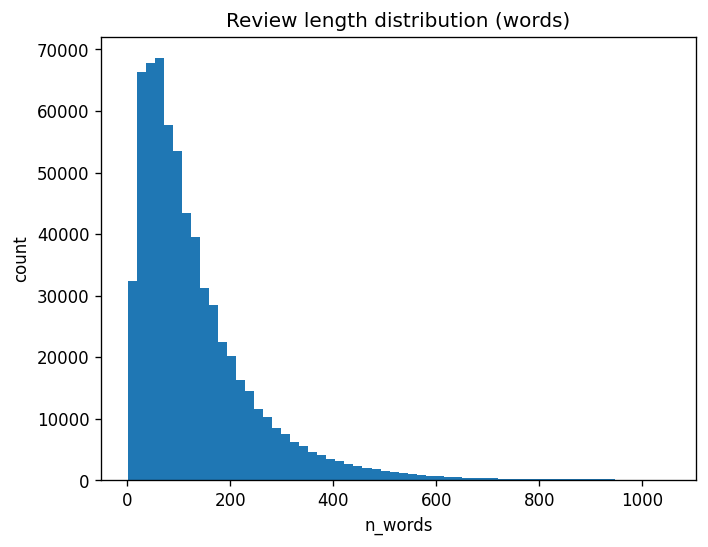

In [23]:
plt.figure()
plt.hist(train_df["n_words"], bins=60)
plt.title("Review length distribution (words)")
plt.xlabel("n_words")
plt.ylabel("count")
plt.show()

The distribution is right skewed with a long tail.
Most reviews are under about 200 words, but a small number are much longer.
This suggests that very short reviews may contain limited signal, while very long reviews may dominate computation if not sampled.

In [24]:
train_df["n_words"].quantile([0.5, 0.9, 0.95, 0.99])


0.50     99.0
0.90    282.0
0.95    370.0
0.99    601.0
Name: n_words, dtype: float64

Half of the reviews are 99 words or fewer.
Only 10 percent are longer than 282 words, and 1 percent are longer than 601 words.
This confirms a strong long tail, so later models can use sampling or caps to keep computation manageable.

In [25]:
length_by_label = train_df.groupby("label")["n_words"].describe()
length_by_label

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,130000.0,151.469100,141.592759,1.0,57.0,108.0,196.0,1052.0
1,130000.0,152.018654,129.290066,1.0,64.0,116.0,199.0,1021.0
2,130000.0,138.626415,116.617138,1.0,59.0,107.0,182.0,973.0
3,130000.0,123.402377,107.547047,1.0,50.0,94.0,163.0,1034.0
4,130000.0,104.973900,100.742982,1.0,40.0,74.0,135.0,956.0


Lower ratings tend to have longer reviews.
This suggests negative reviews may include more details, while positive reviews are often shorter.
This difference may affect classification errors across labels.

In [28]:
import torch
torch.cuda.is_available()

True

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

S = 100000
sample_text = train_df["text_clean"].sample(n=S, random_state=42)

cv = CountVectorizer(stop_words="english", max_features=20000, min_df=5)
X = cv.fit_transform(sample_text)

terms = np.array(cv.get_feature_names_out())
freq = np.asarray(X.sum(axis=0)).ravel()

top_k = 20
idx = np.argsort(-freq)[:top_k]
top_terms = list(zip(terms[idx], freq[idx]))

top_terms

[('food', 60943),
 ('good', 60208),
 ('place', 58458),
 ('like', 48664),
 ('just', 47758),
 ('time', 38195),
 ('great', 37137),
 ('service', 36712),
 ('really', 32061),
 ('don', 24508),
 ('ni', 24037),
 ('got', 23805),
 ('nthe', 23327),
 ('ve', 22085),
 ('didn', 21051),
 ('nice', 20840),
 ('ordered', 20120),
 ('did', 18994),
 ('people', 18952),
 ('came', 18540)]

The most frequent terms are generic review words such as food, good, place, and service.
This suggests the corpus spans many business types and the vocabulary is dominated by common experience and sentiment words.
I also see tokenization artifacts like don, didn, ve, and nthe, which likely come from punctuation or HTML escaping.
This motivates a slightly cleaner text version for later modeling.

In [30]:
def clean_text_v2(s):
    s = str(s).lower()
    s = s.replace("&nbsp;", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

train_df["text_clean2"] = train_df["text"].map(clean_text_v2)
test_df["text_clean2"] = test_df["text"].map(clean_text_v2)

train_df[["text_clean", "text_clean2"]].head(3)


,text_clean,text_clean2
0,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.","dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."
1,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.","unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i've had with so many other doctors in nyc -- good doctor, terrible staff. it seems that his staff simply never answers the phone. it usually takes 2 hours of repeated calling to get an answer. who has time for that or wants to deal with it? i have run into this problem with many other doctors and i just don't get it. you have office workers, you have patients with medical needs, why isn't anyone answering the phone? it's incomprehensible and not work the aggravation. it's with regret that i feel that i have to give dr. goldberg 2 stars."
2,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.","been going to dr. goldberg for over 10 years. i think i was one of his 1st patients when he started at mhmg. he's been great over the years and is really all about the big picture. it is because of him, not my now former gyn dr. markoff, that i found out i have fibroids. he explores all options with you and is very patient and understanding. he doesn't judge and asks all the right questions. very thorough and wants to be kept in the loop on every aspect of your medical health and your life."


I train a simple TF IDF plus logistic regression baseline.
This is a standard course aligned approach and provides a quick sanity check that the labels are predictable from the text.
To keep runtime manageable, I train on a sample and cap the vocabulary size.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

N = 20000

train_small = train_df.sample(n=N, random_state=42)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 1),
    min_df=5,
    stop_words="english"
)

X_train = tfidf.fit_transform(train_small["text_clean2"])
y_train = train_small["label"].values

X_test = tfidf.transform(test_df["text_clean2"])
y_test = test_df["label"].values

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(classification_report(y_test, pred, digits=3))

d:\Coding\Anaconda3\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0      0.644     0.716     0.678     10000
           1      0.461     0.416     0.438     10000
           2      0.437     0.426     0.432     10000
           3      0.449     0.436     0.442     10000
           4      0.615     0.639     0.626     10000

    accuracy                          0.527     50000
   macro avg      0.521     0.527     0.523     50000
weighted avg      0.521     0.527     0.523     50000



The baseline achieves moderate accuracy on 5 classes.
Performance is better on the extreme ratings and weaker on the middle ratings, which suggests many mistakes may happen between adjacent stars.
To inspect this, I plot the confusion matrix.

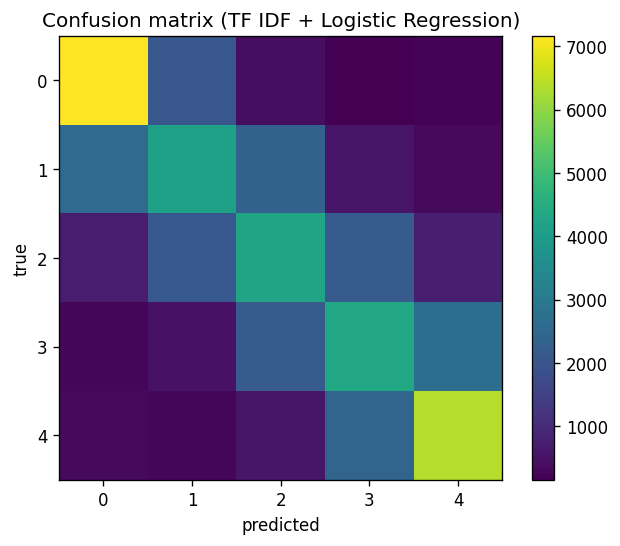

array([[7160, 2044,  416,  156,  224],
       [2605, 4164, 2325,  566,  340],
       [ 728, 2089, 4259, 2177,  747],
       [ 291,  495, 2159, 4360, 2695],
       [ 340,  241,  580, 2452, 6387]], dtype=int64)

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion matrix (TF IDF + Logistic Regression)")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()
plt.show()

cm


In [33]:
row_acc = np.diag(cm) / cm.sum(axis=1)
row_acc


array([0.716 , 0.4164, 0.4259, 0.436 , 0.6387])

Most errors occur between adjacent labels. Per class accuracy is highest for the extreme ratings.
Label 0 has about 0.716 accuracy and label 4 has about 0.639 accuracy.
The middle labels are much lower, around 0.416 to 0.436.
This matches the confusion matrix and suggests the main difficulty is separating adjacent middle ratings.

# (E) Initial insights and direction

## Initial observations
Observation 1  
The dataset has no missing text or labels and the training split is perfectly balanced across 5 classes  
Observation 2  
Review length is right skewed with a long tail and lower ratings tend to have longer reviews  
Observation 3  
A simple TF IDF baseline reaches about 0.53 accuracy and the main errors are between adjacent middle ratings 1 2 3 while extreme ratings 0 and 4 are easier  

## Working hypothesis
Hypothesis  
Middle star ratings share overlapping language and topics so bag of words features struggle to separate them while extreme ratings contain clearer sentiment cues  

## Potential research questions
RQ 1  
How does model performance change across review length buckets and across labels  
RQ 2  
Can topic modeling or embedding based representations better separate middle star ratings than TF IDF  
RQ 3  
Does treating stars as an ordinal target improve results compared to plain multi class classification  
